In [12]:
from pathlib import Path
from time import time

#import faiss
import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_samples, silhouette_score

In [131]:

SAVE_DIR=Path('./cluster-analysis-plots/')
SAVE_DIR.mkdir(exist_ok=True, parents=True)

EMOJIS =["⚖", "☑", "⌨",  "✑", "🂱"]
DOMAINS = ['Juridical', 'Instructional', 'Virtual', 'Journalistic', 'Entertainment']
NDOMAINS = len(DOMAINS)
COLORS = sns.color_palette('colorblind', NDOMAINS*2 + 1)
PALETTE = { (EMOJIS[i]+','+EMOJIS[j]) : COLORS[k] for k, (i, j) in enumerate(((i, j) for i in range(NDOMAINS) for j in range(NDOMAINS) if i < j)) }
# PALETTE = { (EMOJIS[i]+','+EMOJIS[j]) : COLORS[i+2*j] for i in range(NDOMAINS) for j in range(NDOMAINS) if i > j }
PALETTE[','.join(EMOJIS)] = COLORS[NDOMAINS*2]
PALETTE['All'] = COLORS[NDOMAINS*2]
PALETTE = { k : COLORS[9] for k in PALETTE.keys() }
PALETTEO = { EMOJIS[i] : COLORS[k] for i, k in enumerate([3, 1, 0, 2, 4])}

In [87]:
COLORS

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)]

In [14]:
def to_label(i):
    global EMOJIS
    return EMOJIS[i]# +  ' ' + d[i]

def sample(size, classes, x, y, seed=42):
    X = []
    Y = []
    rng = np.random.default_rng(seed)
    for c in classes:
        yc = y == c
        yt = y[yc]
        xt = x[yc]
        indices = rng.choice(np.arange(xt.shape[0]), size, replace=False)
        X.append(xt[indices])
        Y.append(yt[indices])
    X = np.concatenate(X)
    Y = np.concatenate(Y)
    return X, Y

def read(path):
    with np.load(path) as f:
        x, y, l, o = f['x'], f['y'], f['l'], f['o']
    return x, y, l, o

In [15]:
def mean(x, l):
    lm = np.repeat(l.reshape((-1, 1)), (x.shape[1]), axis=1)
    return x / lm

In [16]:
# Gráfico com a média das siluetas 2 a 2
def silhouettes(x, y, npoints=200, verbose=True):
    labels = np.unique(y)
    results = dict()
    ms = []
    ss = []
    for i in labels:
        for j in labels:
            if j <= i: continue
            s = sample(npoints, [i, j], x, y, seed=42)
            ssamples = silhouette_samples(s[0], s[1], metric='cosine')
            lij = (i, j)
            ms.append(np.mean(ssamples))
            ss.append(np.std(ssamples, ddof=1)/np.sqrt(np.size(ssamples)))
            if verbose:
                print(lij, ms[-1], ss[-1])
            results[lij] = ssamples
    print('Mean:', np.mean(ms), "std:", np.mean(ss))
    s = sample(npoints, labels, x, y, seed=42)
    ssamples = silhouette_samples(s[0], s[1], metric='cosine')
    results[tuple(labels)] = ssamples
    if verbose:
        print(tuple(labels), np.mean(ssamples), np.std(ssamples, ddof=1)/np.sqrt(np.size(ssamples)))
    return results

In [217]:
def plot_silhouettes(silhouettes, title):
    global PALETTE
    keys = []
    values = []
    for key, value in sorted(silhouettes.items(), key=lambda x: np.mean(x[1])):
        k = ','.join(map(to_label, key)) if len(key) == 2 else 'All'
        for v in value:
            keys.append(k)
            values.append(v)
        
    #d = { ','.join(map(to_label, k)) : np.mean(v) for k, v in silhouettes.items() }
    #n, v = zip(*d.items())
    df = pd.DataFrame.from_dict({'Sets of Discourse Domains' : keys, 'Silhouette' : values})
    sns.set_theme(context='poster')
    #sns.set(font_scale=2.5)
    #sns.set(axis_fgcolor=COLORS[9])
    fig = sns.catplot(data=df, y='Silhouette', x='Sets of Discourse Domains', hue='Sets of Discourse Domains', 
             kind='bar', palette=PALETTE, legend=False, height=5.0, aspect=2.7)         
             # kind='bar', palette=PALETTE, legend=False, height=5.0, aspect=3.0)
    #fig = sns.barplot(data=df, y='silhouette', x='domains', hue='domains', palette=PALETTE, legend=False, height=2.5, aspect=2.0)
    fig.set(title=title,ylim=(-0.02, 0.35))
    fig.set_xticklabels(rotation=60, size=40)
    fig.set_xlabels('Sets of Discourse Domains', fontsize=35)
    fig.set_ylabels('Silhouette', fontsize=35)
    ax = fig.facet_axis(0, 0)  # or ax = g.axes.flat[0]
    # iterate through the axes containers
    for c in ax.containers:
        labels = [f'{(v.get_height()):.3f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
        #ax.set_xlabel("Sets of Discourse Domains", fontsize=40)
    return fig

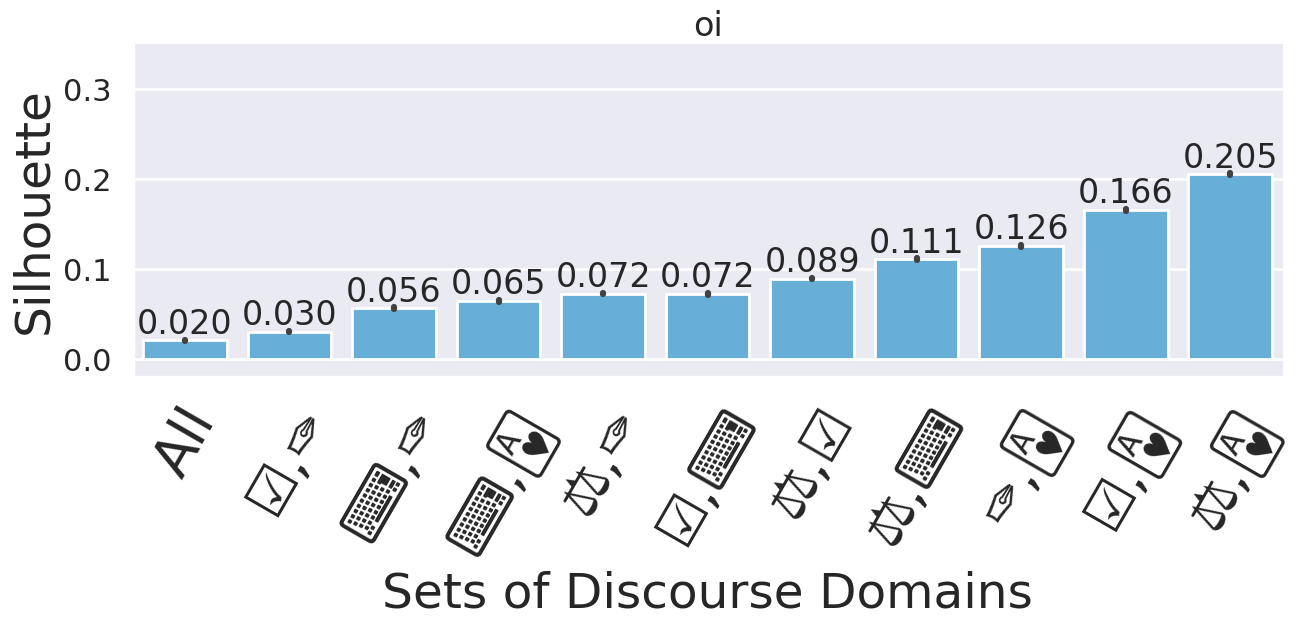

In [218]:
# faiss kmeans
plot_silhouettes(res, 'oi')

In [219]:
def plot_oovs(o, y, title):
    global PALETTEO
    df = pd.DataFrame.from_dict({'oovs' : o, 'Discourse Domain' : list(map(to_label, y))})
    sns.set_theme(context='poster')
    #sns.set(font_scale=20.0)
    fig = sns.catplot(
        data=df, x='Discourse Domain', hue='Discourse Domain',
        palette=PALETTEO, legend=False, kind='count', height=5, aspect=2.7)
    fig.set(title=title, ylim=(0, 1e7))#, ylabel='Count')
    fig.set_xticklabels(size=35)
    #fig.set_xticklabels(rotation=60, size=25)
    fig.set_xlabels('Discourse Domain', fontsize=35)
    fig.set_ylabels('Count', fontsize=35)
    ax = fig.facet_axis(0, 0)  # or ax = g.axes.flat[0]
    # iterate through the axes containers
    for c in ax.containers:
        labels = [f'{(v.get_height()):.1e}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    return fig

In [19]:
datasets = [ f for f in Path('experiments/vectors2/').iterdir() if f.is_file() ]; datasets.sort()

In [202]:
datasets[1]

PosixPath('experiments/vectors2/cbow_s50.npz')

Silhouette for CBOW with dimension 50
(0, 1) 0.08889224048256698 0.0003616601711056272
(0, 2) 0.11079928477147614 0.0006361355728578498
(0, 3) 0.07214426977048063 0.000337183967040321
(0, 4) 0.20497096788381813 0.0005691526171290811
(1, 2) 0.07223857790727677 0.000640845161413465
(1, 3) 0.029811783048948274 0.0002660221674641721
(1, 4) 0.1658309858992994 0.0005929328512278465
(2, 3) 0.05638828916029724 0.0005284926657078884
(2, 4) 0.06463604801053979 0.0006403924855193622
(3, 4) 0.1257618906221482 0.0006035676555933546
Mean: 0.09914743375568516 std: 0.0005176385315058969
(0, 1, 2, 3, 4) 0.020365741226306116 0.00035337068274179207


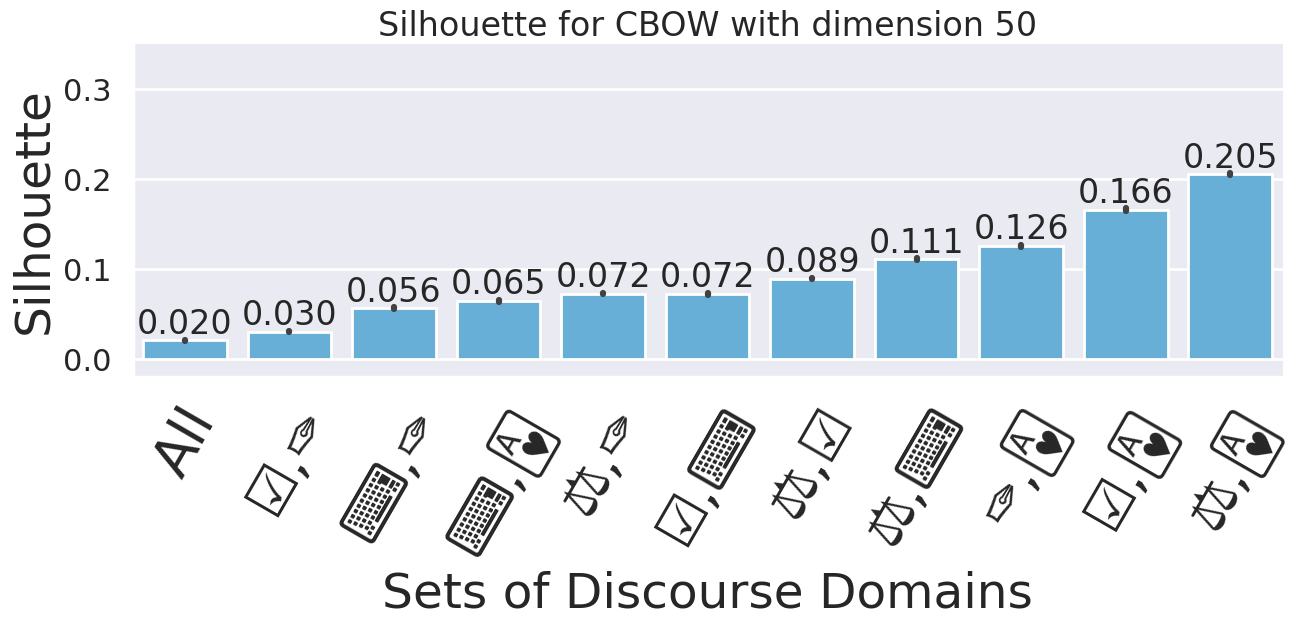

In [221]:
FORCE=True
for dataset in datasets[1:2]:
    oname = dataset.name.replace('.npz', '')
    name = 'Silhouette for ' + oname.upper().replace('_S', ' with dimension ')
    out = SAVE_DIR / (oname + '.png')
    if not out.exists() or FORCE:
        print(name)
        x, y, l, o = read(dataset)
        xm = mean(x, l)
        res = silhouettes(xm, y, npoints=20_000, verbose=True)
        g = plot_silhouettes(res, name)
        g.savefig(out)

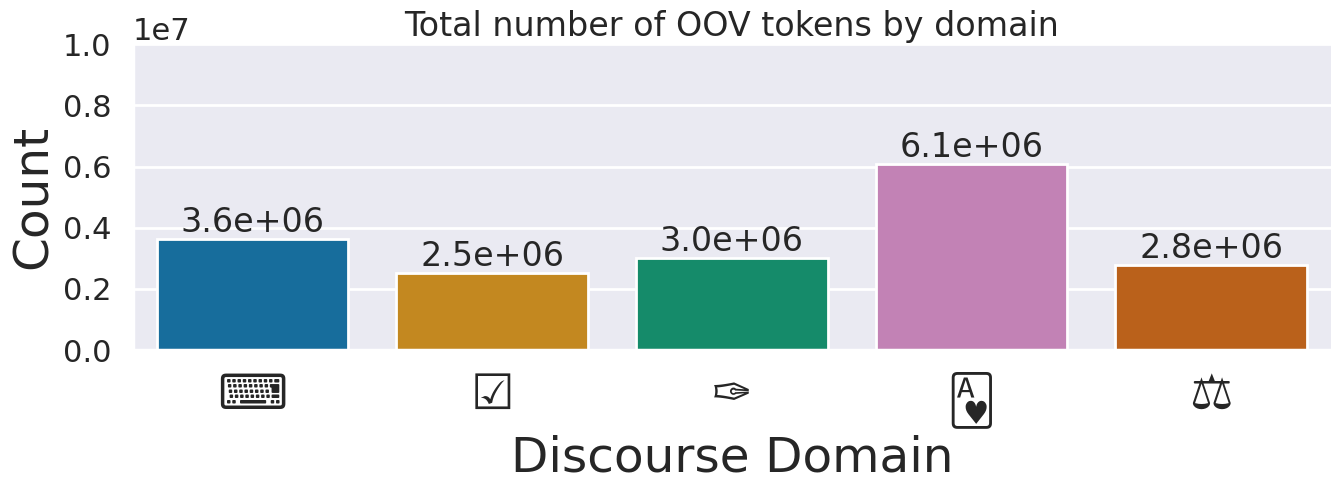

In [220]:
g = plot_oovs(o, y, 'Total number of OOV tokens by domain')
g.savefig(SAVE_DIR / 'oovs.png')